In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from statistics import mean
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pandas.core.common import SettingWithCopyWarning
import warnings
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import pickle
import sys
from sys import exc_info

## Loading the data

Source and Tutorial: https://asdkazmi.medium.com/ai-movies-recommendation-system-with-clustering-based-k-means-algorithm-f04467e02fcd

In [2]:
user_rating = pd.read_csv('./datasets/user_score_data.csv', usecols=['user_id', 'mal_id', 'rating'], 
                                  dtype={'user_id':'int32', 'mal_id':'int32', 'rating':'float32'})

In [3]:
print('Shape of ratings dataset is: ', user_rating.shape, '\n')
print('Max values in dataset are \n', user_rating.max(), '\n')
print('Min values in dataset are \n', user_rating.min(), '\n') 

Shape of ratings dataset is:  (948898, 3) 

Max values in dataset are 
 user_id     2195.0
mal_id     42913.0
rating        10.0
dtype: float64 

Min values in dataset are 
 user_id    1.0
mal_id     1.0
rating     0.0
dtype: float64 



## Pick only data user that have 4+ rating

In [4]:
user_rating = user_rating[user_rating['rating'] >= 4.0]

In [5]:
users_list = np.unique(user_rating['user_id'])[:100]
ratings = user_rating.loc[user_rating['user_id'].isin(users_list)]

In [6]:
fav_movies = ratings.loc[:, ['user_id', 'mal_id']]

In [7]:
fav_movies = ratings.reset_index(drop = True)

In [8]:
fav_movies.T

,0,1,2,3,4,5,6,7,8,9,...,30359,30360,30361,30362,30363,30364,30365,30366,30367,30368
user_id,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
mal_id,29978.0,2467.0,28789.0,34881.0,101.0,713.0,36032.0,656.0,1485.0,17901.0,...,4224.0,33352.0,10015.0,15489.0,21595.0,16576.0,1195.0,11319.0,1840.0,3712.0
rating,6.0,10.0,6.0,6.0,10.0,8.0,8.0,5.0,10.0,6.0,...,10.0,10.0,9.0,7.0,7.0,8.0,10.0,9.0,10.0,9.0


In [9]:
fav_movies.to_csv('./datasets/filtered_ratings.csv')

In [10]:
def userMovieList(users, users_data):
    # users = a list of users IDs
    # users_data = a dataframe of users favourite movies or users watched movies
    users_movies_list = []
    for user in users:
        users_movies_list.append(str(list(users_data[users_data['user_id'] == user]['mal_id'])).split('[')[1].split(']')[0])
    return users_movies_list

In [11]:
user = np.unique(fav_movies['user_id'])

In [12]:
users_movies_list = userMovieList(user, fav_movies)

## Sparse Matrix on the dataset

In [13]:
def prepMatrix(list_of_str):
    # list_of_str = A list, which contain strings of users favourite movies separate by comma ",".
    cv = CountVectorizer(token_pattern = r'[^\,\ ]+', lowercase = False)
    sparseMatrix = cv.fit_transform(list_of_str)
    return sparseMatrix.toarray(), cv.get_feature_names()

In [14]:
sparseMatrix, feature_names = prepMatrix(users_movies_list)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [15]:
df_sparseMatrix = pd.DataFrame(sparseMatrix, index = user, columns = feature_names)
df_sparseMatrix

,1,100,1000,10012,10015,10017,1002,10020,10029,1003,...,996,9963,9969,997,9981,9982,9988,9989,9996,9999
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,1,0,1,0,0
3,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
99,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Clustering Model – Elbow Method

In [69]:
class method():
    def __init__(self, sparseMatrix):
        self.sparseMatrix = sparseMatrix
        self.wcss = list()
        self.dif = list()
    def run(self, init, upto, max_iterations = 300):
        for _ in range(init, upto + 1):
            kmeans = KMeans(n_clusters = _, init = 'k-means++', max_iter = max_iterations, n_init = 5, random_state = 99)
            kmeans.fit(sparseMatrix)
            self.wcss.append(kmeans.inertia_)
        self.dif = list()
        for i in range(len(self.wcss) - 1):
            self.dif.append(self.wcss[i] - self.wcss[i + 1])
    def showPlot(self, boundary = 500, up_cluster = None):
        if up_cluster is None:
            WCSS = self.wcss
            DIFF = self.dif
        else:
            WCSS = self.wcss[:up_cluster]
            DIFF = self.dif[:up_cluster - 1]
        plt.figure(figsize=(15, 6))
        plt.subplot(121).set_title('Elbow Method Graph')
        plt.plot(range(1, len(WCSS) + 1), WCSS)
        plt.grid(b = True)
        plt.subplot(122).set_title(' Two Difference Consective Clusters')
        len_dif = len(DIFF)
        X_dif = range(1, len_dif + 1)
        plt.plot(X_dif, DIFF)
        plt.plot(X_dif, np.ones(len_dif) * boundary, 'r')
        plt.plot(X_dif, np.ones(len_dif) * (-boundary), 'r')
        plt.grid()
        plt.show()
        plt.savefig('k-mean.png')

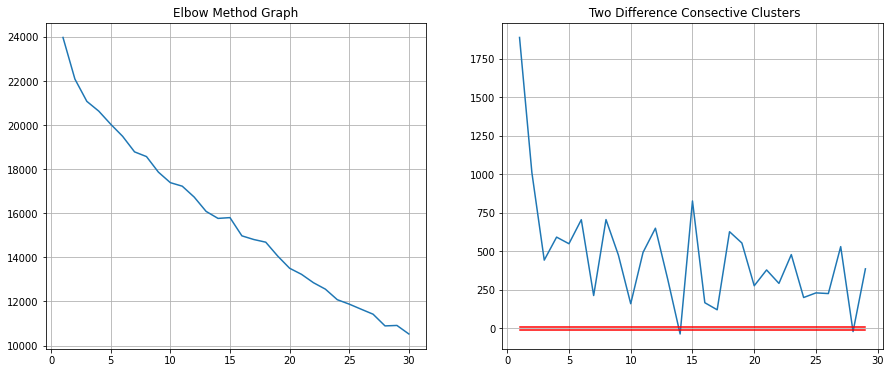

<Figure size 432x288 with 0 Axes>

In [70]:
elbow = method(sparseMatrix)
elbow.run(1, 30)
elbow.showPlot(boundary = 10)

From the graph above, we observe there is isn't any elbow within our dataset. Though, if we look at the difference graph, we can observe that after the cluster with k = 14, though it is hard to observe the boundary. Therefore, we will run k-mean with clusters of 15. Since the analyze of optimal clusters for k complete – we will move to the model and create recommendation based on the model result.

## K-Mean Clustering Table Fitting

In [18]:
kmeans = KMeans(n_clusters = 14, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 99)
clusters = kmeans.fit_predict(sparseMatrix)

In [19]:
users_cluster = pd.DataFrame(np.concatenate((user.reshape(-1,1), clusters.reshape(-1,1)), axis = 1), columns = ['user_id', 'Cluster'])
users_cluster.T

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
user_id,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
Cluster,9,12,8,1,1,1,1,1,3,7,...,3,3,1,1,1,1,1,1,1,1


In [20]:
for _ in range(15):
    user = users_cluster[users_cluster['Cluster'] == _].shape[0]
    print('User within the cluster ' + str(_) + ' =', user)

User within the cluster 0 = 1
User within the cluster 1 = 70
User within the cluster 2 = 1
User within the cluster 3 = 18
User within the cluster 4 = 1
User within the cluster 5 = 1
User within the cluster 6 = 1
User within the cluster 7 = 1
User within the cluster 8 = 1
User within the cluster 9 = 1
User within the cluster 10 = 1
User within the cluster 11 = 1
User within the cluster 12 = 1
User within the cluster 13 = 1
User within the cluster 14 = 0


## A Function to get user movies list

In [21]:
def getMovies(user_id, users_data):
    return list(users_data[users_data['user_id'] == user_id]['mal_id'])

## Save and load training data 

In [22]:
#Source: https://asdkazmi.medium.com/ai-movies-recommendation-system-with-clustering-based-k-means-algorithm-f04467e02fcd
class saveLoadFiles:
    def save(self, filename, data):
        try:
            file = open('datasets/' + filename + '.pkl', 'wb')
            pickle.dump(data, file)
        except:
            err = 'Error: {0}, {1}'.format(exc_info()[0], exc_info()[1])
            print(err)
            file.close()
            return [False, err]
        else:
            file.close()
            return [True]
    def load(self, filename):
        try:
            file = open('datasets/' + filename + '.pkl', 'rb')
        except:
            err = 'Error: {0}, {1}'.format(exc_info()[0], exc_info()[1])
            print(err)
            file.close()
            return [False, err]
        else:
            data = pickle.load(file)
            file.close()
            return data
    def loadClusterMoviesDataset(self):
        return self.load('clusters_movies_dataset')
#     def saveClusterMoviesDataset(self, data):
#         return self.save('clusters_movies_dataset', data)
    def loadUsersClusters(self):
        return self.load('users_clusters')
#     def saveUsersClusters(self, data):
#         return self.save('users_clusters', data)

## Creating a class function for genre recommendatio based on on user history 

In [23]:
class request:
    def __init__(self, user_id, users_data):
        self.users_data = users_data.copy()
        self.user_id = user_id
        
        # Find User Cluster
        usersCluster = saveLoadFiles().loadUsersClusters()
        self.usersCluster = int(usersCluster[usersCluster['user_id'] == self.user_id]['Cluster'])
        
        # Load User Cluster Movies Dataframe
        self.moviesList = saveLoadFiles().loadClusterMoviesDataset()
        self.cluster_movies = self.moviesList[self.usersCluster] # dataframe
        self.clusterMovies = list(self.cluster_movies['mal_id']) # list
        
    def recommendGenre(self):
        try:
            user_movies = getMovies(self.user_id, self.users_data)
            clusterMovies= self.clusterMovies.copy()
            for user_movie in user_movies:
                if user_movie in clusterMovies:
                    clusterMovies.remove(user_movie)
            return [True, clusterMovies]
        except KeyError:
            return False

## Merging two datasets based on 'mal_id'

In [24]:
animes_df = pd.read_csv('./datasets/anime_data.csv', usecols=['mal_id', 'title', 'genres'])
animes_df.head(3)

,mal_id,genres,title
0,1,"['Action', 'Adventure', 'Comedy', 'Drama', 'Sc...",Cowboy Bebop
1,100,"['Comedy', 'Drama', 'Fantasy', 'Magic', 'Roman...",Shin Shirayuki-hime Densetsu Prétear
2,1000,"['Action', 'Sci-Fi', 'Adventure', 'Space', 'Dr...",Uchuu Kaizoku Captain Herlock


In [25]:
filled_data = pd.read_csv('./datasets/complete_user_ratings.csv', usecols=['mal_id', 'rating', 'favorited'])
filled_data.head(3)

,mal_id,rating,favorited
0,29978,6.0,0.0
1,2467,10.0,0.0
2,28789,6.0,0.0


In [26]:
df = fav_movies.merge(animes_df, on = 'mal_id')
df.head(3)

,user_id,mal_id,rating,genres,title
0,1,29978,6.0,['Comedy'],001
1,36,29978,5.0,['Comedy'],001
2,70,29978,5.0,['Comedy'],001


## Merge with dataset that applied with linear regression

In [49]:
new_merge = df.merge(filled_data, on = 'mal_id')
new_merge.head(3)

,user_id,mal_id,rating_x,genres,title,rating_y,favorited
0,1,29978,6.0,['Comedy'],001,6.0,0.0
1,1,29978,6.0,['Comedy'],001,0.0,0.0
2,1,29978,6.0,['Comedy'],001,1.0,0.0


## Get a list movies based on user_id and genre

In [48]:
userMovie = getMovies(5, new_merge)
for i in userMovie[:1]:
    title = list(new_merge.loc[new_merge['user_id'] == 5]['title'])
    if title != 0:
        print('Movie title: ', title[:10])

Movie title:  ['Boku no Hero Academia', 'Code Geass: Hangyaku no Lelouch', 'Dagashi Kashi', 'Death Note', 'Death Parade', 'Gyakkyou Burai Kaiji: Hakairoku-hen', 'Gyakkyou Burai Kaiji: Ultimate Survivor', 'Hunter x Hunter (2011)', 'Hyouka', 'Inuyashiki']


## Genre Recommendation system based on user_id

In [43]:
genresRecommendations = request(21, fav_movies).recommendGenre()
for movie in genresRecommendations[:1]:
    title = list(new_merge.loc[new_merge['user_id'] == 21]['title'])
    if title != []:
        genres = ast.literal_eval(new_merge.loc[new_merge['user_id'] == 21]['genres'].values[0].split('[')[1].split(']')[0])
        for genre in genres:
            print(genre)

Action
Fantasy
Game

